In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numba as nb
import pandas_ta
import os
import datetime
import json
import seaborn as sns
from tabulate import tabulate
import sys
sys.path.append('../..')
import vectorbt as vbt
from vectorbtpro.portfolio.enums import SizeType
from src.utils import fu
from src.utils import plot_return_mdd
from src.strategy.BackTester import BackTester
from src.strategy.Analyzer import Analyzer
from src.strategy.MultiTester import MultiTester
from src.utils import plot_return_mdd,twinx_plot # as utils
from week_corr_v1 import get_data,Strategy
sns.set_style("darkgrid")

In [8]:
df_dict = {}
candidate = ['BTC','ETH','SOL','XRP']

for coin in candidate:
    df_dict[coin] = get_data(coin)

APY: 47.57 %
MDD: 14.88 %
MDD Duration 203 days 01:00:00
worst trade: -11.06 %
2022-02-27 00:00:00 ~ 2022-02-28 22:00:00
avg holding days: 1.37 days
--------------------------------------------
PF: 1.90
Sharpe Ratio: 1.72
Calmar Ratio: 2.67
Sortino Ratio: 2.61
Omega Ratio: 1.14
--------------------------------------------
Expectancy : 0.80 %
Total Time Exposure : 22.34 %
Total Trades: 118
Win Rate: 52.54 %
--------------------------------------------
PF * Win Rate: 0.998


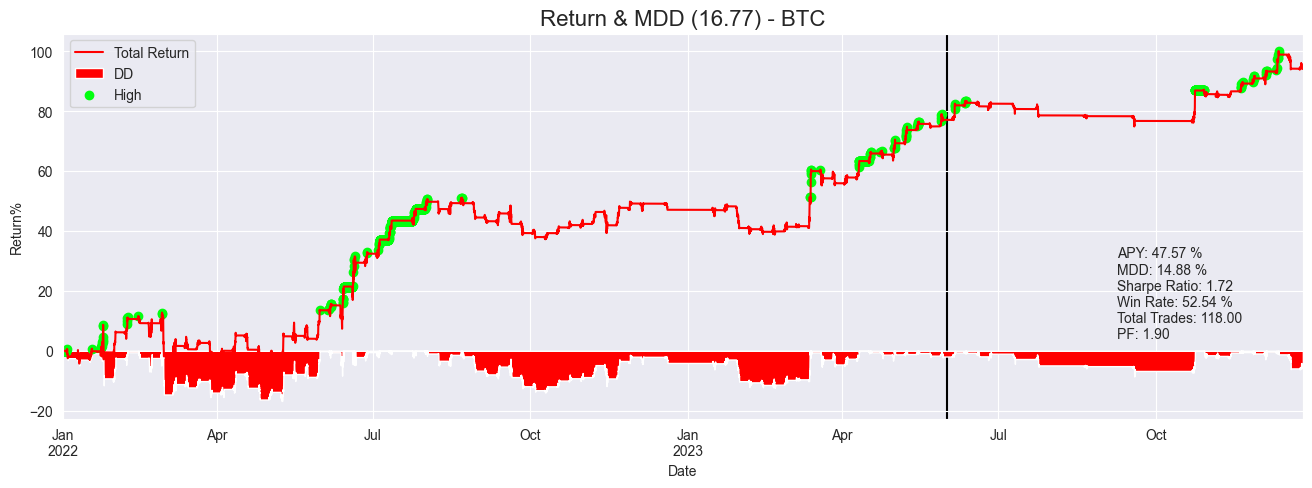

In [10]:
start = '2022-01-01'
sep = ''
end = ''

side = 'both'
params ={'vol_threshold': 4.0, 'ret_threshold': 0.15, 'stop_loss': np.nan}

config = {'freq':'1h', 'lag':1, 'fee': 0.0003}
coin = 'BTC'
df = df_dict[coin]
strategy = Strategy(df=df.loc[start:], configs=config)
_pf = strategy.strategy(side = side,params=params)
trades = _pf.trades.records_readable
analyze = Analyzer(strategy)
value = analyze.show_pf_analysis(params, side, coin, axv_index=['2023-06-01'])

In [4]:
start= '2022-01-01'
end ='2023-06-01'

params={
    'vol_threshold': [0.0, 5, 0.5],
    'ret_threshold' : [0.1, 0.5, 0.05],
    'stop_loss': [5,11,1]
    }
    
config = {'freq':'1h','fee': 0.0003}
symbol_list = ['BTC']
sample_sets = [[start,end]]

multi_test = MultiTester(
    Strategy,
    get_data_func=get_data,
    params=params,
    config=config,
    df_dict=df_dict,
    symbol_list=symbol_list,
    start=start,
    end=end
    )

======================= BTC BOTH Optimize Test =======================
Optimization trails: 480


100%|██████████| 480/480 [01:38<00:00,  4.87it/s]


Optimization time: 102.24 sec
---------- BTC BOTH ----------
{'vol_threshold': 4.0, 'ret_threshold': 0.15000000000000002, 'stop_loss': 6}
APY: 58.07 %
MDD: 12.25 %
MDD Duration 203 days 01:00:00
worst trade: -6.06 %
2022-02-27 00:00:00 ~ 2022-02-28 16:00:00
avg holding days: 1.39 days
--------------------------------------------
PF: 1.98
Sharpe Ratio: 1.95
Calmar Ratio: 4.30
Sortino Ratio: 2.98
Omega Ratio: 1.15
--------------------------------------------
Expectancy : 0.90 %
Total Time Exposure : 24.38 %
Total Trades: 91
Win Rate: 52.75 %
--------------------------------------------
PF * Win Rate: 1.047


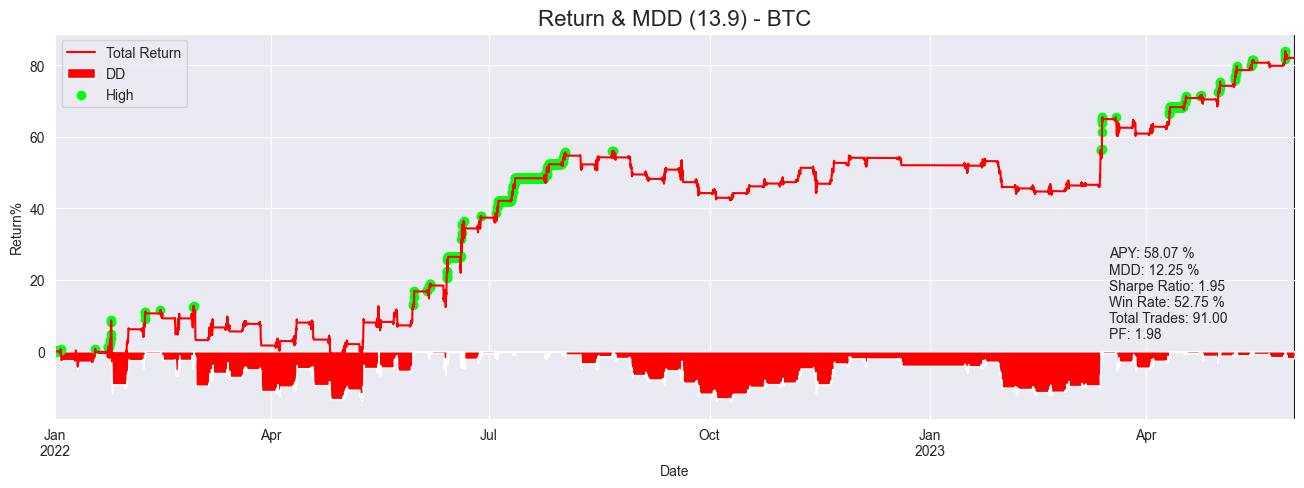

+------------+-----------+---------+----------+------------+---------+------------+
| datetime   |   收益率% |    毛利 |     毛損 |   獲利因子 |   勝率% |   交易次數 |
|------------+-----------+---------+----------+------------+---------+------------|
| 2022-03    |      1.7  | 2411.89 | -2247.9  |       1.07 |   47.06 |         17 |
| 2022-06    |     35.85 | 5696.45 | -2120.1  |       2.69 |   57.89 |         19 |
| 2022-09    |      6.88 | 2240.31 | -1552.05 |       1.44 |   35.29 |         17 |
| 2022-12    |      7.77 | 1601.56 |  -824.72 |       1.94 |   53.85 |         13 |
| 2023-03    |      8.87 | 2353.57 | -1466.86 |       1.6  |   56.25 |         16 |
| 2023-06    |     21.17 | 2240.28 |  -123.78 |      18.1  |   77.78 |          9 |
+------------+-----------+---------+----------+------------+---------+------------+


In [5]:
all_params = multi_test.multi_params(symbol_list,sample_sets,direction='both')
trades, value_df = multi_test.multi_params_result(all_params)
# multi_test.save_version_result(all_params,value_df,trades,1)